In [1]:
import torch
from transformers import MT5ForConditionalGeneration, MT5Config, MT5EncoderModel, MT5Tokenizer, Trainer, TrainingArguments
from progeny_tokenizer import TAPETokenizer
import numpy as np
import math
import random
import scipy
import time
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, Dataset, BatchSampler
import typing
from pathlib import Path
import argparse
from collections import OrderedDict
import pickle
import matplotlib.pyplot as plt

from tape.metrics import spearmanr

In [2]:
before_foldx = False

# Analyze 250K gen seqs and prepare for FoldX

saved output tsv file to run FoldX inference

In [3]:
wt_seq = 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ'
constant_region = 'NTNITEEN'
wt_cs_ind = wt_seq.index(constant_region)

In [4]:
gen250k_tsv_name = 'generated_seqs/congen/clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000.tsv'
# gen250k_tsv_name = 'generated_seqs/congen/clspool_sephead512dim_lre-04_gen_perturb-1/unique250K_clspool_sephead512dim_lre-04_gen_perturb-1-congen_seqs260000.tsv'

In [5]:
gen250k_df = pd.read_table(gen250k_tsv_name)

In [6]:
gen250k_df

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
0,0.207260,-9.537679,STIEEQAKTFLDKFNHEAEDLFYQSLLALMNYNTNYEEENVQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLALWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
1,0.249788,-5.829383,STIEEQAKTFLDKFNHEAEDLVYQSMLAMMNLALDKMSAFLKEQST...,STIEEQAKTFLDKFNHEAEDLVYQSWLAWWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
2,0.252830,-6.095621,SSIEEQAKTFLDKFNHEAEDLFSQSSLASMNYELEKMSAFLKEVST...,STIEEQAKTFLDKFNHEAEDLNYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
3,0.254230,-4.623075,STIEEQAKTFLDKFNHEAEDLFYQSSLYNMNYDLDKMSAFLKEIST...,STIEEQAKTFLDKFNHEAEDLFYQSSLYEWNYNTNITEENVQDMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
4,0.278016,-1.535025,SDIEE<sep><pad><pad><pad><pad><pad><pad><pad><...,SDIEELARTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
260072,31.973324,-0.064639,STIEEQYKTFLDKFNHEAEDLAYQSSLASMNYNTNITEENVQNMNN...,STIEEQVKTFLDKFNHEAEDLRYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260073,32.976631,3.052268,STIEEQFKTFLDKFNHEAEDLDLESLLASMNLNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDEFYKMSLASWNLNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260074,33.020695,3.490308,STIEEQFKTFLDKFNHEAEDLMYQSSLASMNYNTNITEENVYMMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260075,33.379665,3.783327,STIEEQYKTFLSKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFTHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


filter out sequences without constant region

In [7]:
indices_to_drop = []
dropped_seqs = []
for index, row in gen250k_df.iterrows():
    seq = row['MT_seq']
    if constant_region not in seq:
        indices_to_drop.append(index)
        dropped_seqs.append(seq)
    else:
        cs_ind = seq.index(constant_region)
        if cs_ind != wt_cs_ind:
            indices_to_drop.append(index)
            dropped_seqs.append(seq)

In [8]:
print(len(indices_to_drop))
print(indices_to_drop)
print(dropped_seqs)

1771
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 66, 124, 144, 278, 335, 468, 509, 580, 791, 814, 841, 916, 1039, 1253, 1302, 1374, 1395, 1464, 1465, 1652, 1982, 2176, 2199, 2602, 2673, 2751, 2991, 3030, 3033, 3110, 3121, 3139, 3203, 3412, 3512, 3581, 3787, 3943, 3975, 4089, 4091, 4310, 4494, 4551, 4627, 4688, 4773, 5082, 5195, 5403, 5488, 5516, 5761, 5777, 5828, 5858, 6156, 6198, 6205, 6807, 7035, 7362, 7987, 7997, 8071, 8084, 8125, 8346, 8464, 8514, 8560, 8594, 8662, 8782, 8894, 9090, 9201, 9337, 9486, 9650, 9935, 10028, 10033, 10413, 10513, 10750, 10916, 11005, 11056, 11246, 11352, 11434, 11461, 11511, 11669, 11751, 11860, 11959, 12419, 12508, 12533, 12783, 12830, 13066, 13614, 13795, 13943, 13960, 14328, 14781, 14782, 15063, 15280, 15341, 15473, 15606, 15843, 15984, 16076, 16172, 16258, 16334, 17015, 17036, 17169, 17202, 17213, 17259, 17729, 17935, 1793

In [9]:
gen250k_df_dropped_nocon = gen250k_df.drop(indices_to_drop)

In [10]:
gen250k_df_dropped_nocon

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
46,2.761555,-9.884186,SDIEHQAKTFLDKFNHEAEDLFLQSSLTSMNYNTNITEENVQNMNN...,SDITEQAKTFLDKFNHKAEDLFYQSSYASWNYNTNITEENVQNMDN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
47,2.765977,-10.908681,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
48,2.767014,-10.079912,SDVEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDVEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
49,2.767704,-9.625082,SDVEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDVEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
50,2.768132,-10.046223,SSIEEQAKTFLDKFNHEAEDLFYQSSLASMMYNTNITEENMQNMNN...,SSIEEQAKTFLDKFNHEAEDLFYQSSLASWMYNTNITEENMQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
260072,31.973324,-0.064639,STIEEQYKTFLDKFNHEAEDLAYQSSLASMNYNTNITEENVQNMNN...,STIEEQVKTFLDKFNHEAEDLRYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260073,32.976631,3.052268,STIEEQFKTFLDKFNHEAEDLDLESLLASMNLNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDEFYKMSLASWNLNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260074,33.020695,3.490308,STIEEQFKTFLDKFNHEAEDLMYQSSLASMNYNTNITEENVYMMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260075,33.379665,3.783327,STIEEQYKTFLSKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFTHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


filter out sequences with non-AA tokens

In [11]:
rejected_tokens = ["<pad>", "<sep>", "<cls>", "<mask>", "<unk>"]

In [12]:
indices_to_drop = []
dropped_seqs = []
for index, row in gen250k_df_dropped_nocon.iterrows():
    seq = row['MT_seq']
    
    for rejected_token in rejected_tokens:
        if rejected_token in seq:
            indices_to_drop.append(index)
            dropped_seqs.append(seq)
            break
            

In [13]:
print(len(indices_to_drop))
print(indices_to_drop)
print(dropped_seqs)

1386
[318, 2311, 5938, 7072, 15695, 17179, 20191, 20491, 22718, 24293, 30136, 35046, 35839, 36466, 37265, 37676, 38222, 38579, 39211, 41915, 45090, 46458, 46571, 49557, 51201, 54977, 55496, 55897, 56124, 57330, 57359, 57374, 60070, 60523, 63611, 64365, 66500, 66569, 69509, 69701, 70389, 71089, 71489, 73468, 74147, 74349, 74938, 75035, 76096, 76604, 77470, 78549, 79867, 80594, 81037, 83741, 83906, 85182, 85279, 85558, 86511, 87114, 89683, 90500, 91135, 91251, 91336, 92604, 92962, 93551, 93686, 94674, 95860, 97098, 101451, 101549, 101690, 101758, 102469, 102601, 103057, 103266, 103524, 104242, 104734, 105460, 106314, 106524, 106700, 106745, 106790, 107320, 107530, 108104, 108324, 108854, 109222, 109715, 110009, 110828, 110869, 111135, 111540, 111762, 113070, 113950, 114113, 114270, 114890, 115672, 117590, 117919, 118375, 118480, 118640, 121101, 121127, 121212, 121383, 122463, 123031, 123666, 123676, 124597, 124621, 125694, 126021, 126294, 127048, 127337, 127395, 128471, 128824, 130162, 1

In [14]:
gen250k_df_dropped = gen250k_df_dropped_nocon.drop(indices_to_drop)
print(len(gen250k_df_dropped))

256920


In [15]:
gen250k_df_dropped

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
46,2.761555,-9.884186,SDIEHQAKTFLDKFNHEAEDLFLQSSLTSMNYNTNITEENVQNMNN...,SDITEQAKTFLDKFNHKAEDLFYQSSYASWNYNTNITEENVQNMDN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
47,2.765977,-10.908681,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
48,2.767014,-10.079912,SDVEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDVEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
49,2.767704,-9.625082,SDVEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDVEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
50,2.768132,-10.046223,SSIEEQAKTFLDKFNHEAEDLFYQSSLASMMYNTNITEENMQNMNN...,SSIEEQAKTFLDKFNHEAEDLFYQSSLASWMYNTNITEENMQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
260072,31.973324,-0.064639,STIEEQYKTFLDKFNHEAEDLAYQSSLASMNYNTNITEENVQNMNN...,STIEEQVKTFLDKFNHEAEDLRYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260073,32.976631,3.052268,STIEEQFKTFLDKFNHEAEDLDLESLLASMNLNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDEFYKMSLASWNLNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260074,33.020695,3.490308,STIEEQFKTFLDKFNHEAEDLMYQSSLASMNYNTNITEENVYMMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260075,33.379665,3.783327,STIEEQYKTFLSKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFTHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


# Filter out sequences that are repeat or in training set

In [16]:
input_data_file = 'data/gen_train_data/top_half_ddG/train_ddG.pkl'
input_data_df = pd.read_pickle(input_data_file)

In [17]:
input_data_df.iloc[0]['MT_seq']

'STIEEQAKTFLMKFNHEAEDLFFQSSLASWNYNTNITEENVANMNNAGDKWIAFLKEQQTLAQMYPLQEIQNLTTKLQLQALQ'

In [18]:
input_data_df.iloc[0]['MT_seq'] in input_data_df['MT_seq']

False

In [19]:
input_data_df.iloc[0]['MT_seq'] in input_data_df['MT_seq'].tolist()

True

In [20]:
train_seq_list = input_data_df['MT_seq'].tolist()

In [21]:
train_seq_list

['STIEEQAKTFLMKFNHEAEDLFFQSSLASWNYNTNITEENVANMNNAGDKWIAFLKEQQTLAQMYPLQEIQNLTTKLQLQALQ',
 'STIEEQAKTFLDKFNNEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLTKFNHEAEDLFYQESLASWNYNTNITEENVQNMNNAGDKWSAFLKMQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLPKFQHEAEDLFYQSSLASWNYNTNITEENVQNMNNAKFKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEKQAKTFLDRFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSIFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDQFNHEATDLFYQSSLASWNYNTNITEENVQNMNNAGDNWSAFLKMQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEHAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNLGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNLAGDKWSAMLKEQSTLAQMYPSQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLRKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLAALQ',
 'NTIEEQAKTFLVKFKHEAEDLFYQDSLASWNYNTNITEENVQNMNNAGDKWSAFLKEQSTLAQMYPLQEIQNLTVKLQLQALQ',
 'STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNQNNAGDKWSAFLKEQSLLAQMYPLQEIQNLTVKLMLQALQ',
 'STIEEQAKTHLDKFNHEAEDLFYQSSLASW

In [22]:
len(train_seq_list)

125000

Filter out those that are repeat

In [23]:
gen250k_df_dropped_norepeat = gen250k_df_dropped[gen250k_df_dropped['repeated_gen'] == False]

In [24]:
gen250k_df_dropped_norepeat

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
46,2.761555,-9.884186,SDIEHQAKTFLDKFNHEAEDLFLQSSLTSMNYNTNITEENVQNMNN...,SDITEQAKTFLDKFNHKAEDLFYQSSYASWNYNTNITEENVQNMDN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
47,2.765977,-10.908681,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
48,2.767014,-10.079912,SDVEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDVEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
49,2.767704,-9.625082,SDVEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDVEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
50,2.768132,-10.046223,SSIEEQAKTFLDKFNHEAEDLFYQSSLASMMYNTNITEENMQNMNN...,SSIEEQAKTFLDKFNHEAEDLFYQSSLASWMYNTNITEENMQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
260072,31.973324,-0.064639,STIEEQYKTFLDKFNHEAEDLAYQSSLASMNYNTNITEENVQNMNN...,STIEEQVKTFLDKFNHEAEDLRYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260073,32.976631,3.052268,STIEEQFKTFLDKFNHEAEDLDLESLLASMNLNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDEFYKMSLASWNLNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260074,33.020695,3.490308,STIEEQFKTFLDKFNHEAEDLMYQSSLASMNYNTNITEENVYMMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260075,33.379665,3.783327,STIEEQYKTFLSKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFTHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


In [25]:
gen250k_df_dropped_norepeat.iloc[0]

disc_pred                                                     2.761555
latent_head_pred                                             -9.884186
MT_seq               SDIEHQAKTFLDKFNHEAEDLFLQSSLTSMNYNTNITEENVQNMNN...
gen_input_seq        SDITEQAKTFLDKFNHKAEDLFYQSSYASWNYNTNITEENVQNMDN...
PDB                                                      template2.pdb
Chain                                                                A
Start_index                                                         19
WT_seq               STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
repeated_gen                                                     False
in_train_data_gen                                                False
Name: 46, dtype: object

Filter out those from the training set

In [26]:
gen250k_df_filtered = gen250k_df_dropped_norepeat[gen250k_df_dropped_norepeat['in_train_data_gen'] == False]
gen250k_df_filtered

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
46,2.761555,-9.884186,SDIEHQAKTFLDKFNHEAEDLFLQSSLTSMNYNTNITEENVQNMNN...,SDITEQAKTFLDKFNHKAEDLFYQSSYASWNYNTNITEENVQNMDN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
47,2.765977,-10.908681,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
48,2.767014,-10.079912,SDVEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDVEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
49,2.767704,-9.625082,SDVEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDVEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
50,2.768132,-10.046223,SSIEEQAKTFLDKFNHEAEDLFYQSSLASMMYNTNITEENMQNMNN...,SSIEEQAKTFLDKFNHEAEDLFYQSSLASWMYNTNITEENMQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
260072,31.973324,-0.064639,STIEEQYKTFLDKFNHEAEDLAYQSSLASMNYNTNITEENVQNMNN...,STIEEQVKTFLDKFNHEAEDLRYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260073,32.976631,3.052268,STIEEQFKTFLDKFNHEAEDLDLESLLASMNLNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEDEFYKMSLASWNLNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260074,33.020695,3.490308,STIEEQFKTFLDKFNHEAEDLMYQSSLASMNYNTNITEENVYMMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVYMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
260075,33.379665,3.783327,STIEEQYKTFLSKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFTHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


In [27]:
gen250k_df_filtered.iloc[0]

disc_pred                                                     2.761555
latent_head_pred                                             -9.884186
MT_seq               SDIEHQAKTFLDKFNHEAEDLFLQSSLTSMNYNTNITEENVQNMNN...
gen_input_seq        SDITEQAKTFLDKFNHKAEDLFYQSSYASWNYNTNITEENVQNMDN...
PDB                                                      template2.pdb
Chain                                                                A
Start_index                                                         19
WT_seq               STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...
repeated_gen                                                     False
in_train_data_gen                                                False
Name: 46, dtype: object

In [28]:
np.sum(gen250k_df_filtered['repeated_gen'])

0

In [29]:
np.sum(gen250k_df_filtered['in_train_data_gen'])

0

In [30]:
topK_saved = 10000

gen250k_df_filtered = gen250k_df_filtered[:250000]

gen250k_df_filtered = gen250k_df_filtered.sort_values(by='latent_head_pred', ascending=True)
# gen250k_df_filtered = gen250k_df_filtered.sort_values(by='disc_pred', ascending=True)
gen250k_df_filtered_topK = gen250k_df_filtered.iloc[:topK_saved]

In [31]:
filtered_LHscored_gen250k_top10K_tsv_name = 'generated_seqs/congen/clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered.tsv'
# filtered_LHscored_gen250k_top10K_tsv_name = 'generated_seqs/congen/clspool_sephead512dim_lre-04_gen_perturb-1/unique250K_clspool_sephead512dim_lre-04_gen_perturb-1-congen_seqs260000_top10Klatentheadfiltered.tsv'

In [32]:
disc_latenthead_cor = spearmanr(gen250k_df_filtered_topK['disc_pred'], gen250k_df_filtered_topK['latent_head_pred'])
print("disc_latenthead_cor: ", disc_latenthead_cor)

disc_latenthead_cor:  -0.2401010836368954


In [33]:
gen250k_df_filtered_sorted_disc = gen250k_df_filtered.sort_values(by='disc_pred', ascending=True)
gen250k_df_filtered_sorted_disc_topK = gen250k_df_filtered_sorted_disc.iloc[:topK_saved]

In [34]:
filtered_Dscored_gen250k_top10K_tsv_name = 'generated_seqs/congen/clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Kdiscfiltered.tsv'
# filtered_Dscored_gen250k_top10K_tsv_name = 'generated_seqs/congen/clspool_sephead512dim_lre-04_gen_perturb-1/unique250K_clspool_sephead512dim_lre-04_gen_perturb-1-congen_seqs260000_top10Kdiscfiltered.tsv'

In [35]:
all250K_disc_latenthead_cor = spearmanr(gen250k_df_filtered['disc_pred'], gen250k_df_filtered['latent_head_pred'])
print("all250K_disc_latenthead_cor: ", all250K_disc_latenthead_cor)

all250K_disc_latenthead_cor:  0.9027374908587169


# Save top 10K seqs for FoldX Evaluation

In [36]:
if before_foldx:
    gen250k_df_filtered_topK.to_csv(filtered_LHscored_gen250k_top10K_tsv_name, sep="\t", index=False)
    gen250k_df_filtered_sorted_disc_topK.to_csv(filtered_Dscored_gen250k_top10K_tsv_name, sep="\t", index=False)

In [37]:
len(gen250k_df_filtered_topK)

10000

In [38]:
df_toplot = gen250k_df_filtered

# Analyze hamming distance

In [39]:
# Compute hamming distance between MT and WT
def hamming_dist(str1, str2):
    i = 0
    count = 0
 
    while(i < len(str1)):
        if(str1[i] != str2[i]):
            count += 1
        i += 1
    return count

In [40]:
hamming_dist_list = []

In [41]:
wt_seq = df_toplot.iloc[0]['WT_seq']

In [42]:
for index, row in df_toplot.iterrows():
    gen_seq = row['MT_seq']
    h_dist = hamming_dist(gen_seq, wt_seq)
    hamming_dist_list.append(h_dist)

In [43]:
print("Hamming distance stats")
print("max: ", np.max(hamming_dist_list))
print("min: ", np.min(hamming_dist_list))
print("median: ", np.median(hamming_dist_list))
print("mean: ", np.mean(hamming_dist_list))
print("std: ", np.std(hamming_dist_list))

Hamming distance stats
max:  47
min:  2
median:  7.0
mean:  7.156048


hamming distance for generator training data

In [44]:
gen_train_data = 'data/gen_train_data/top_half_ddG/train_ddG.pkl'

In [45]:
gen_train_df = pd.read_pickle(gen_train_data)
wt_seq = gen_train_df.iloc[0]['WT_seq']

gen_train_hamming_dist_list = []
for index, row in gen_train_df.iterrows():
    train_seq = row['MT_seq']
    h_dist = hamming_dist(train_seq, wt_seq)
    gen_train_hamming_dist_list.append(h_dist)

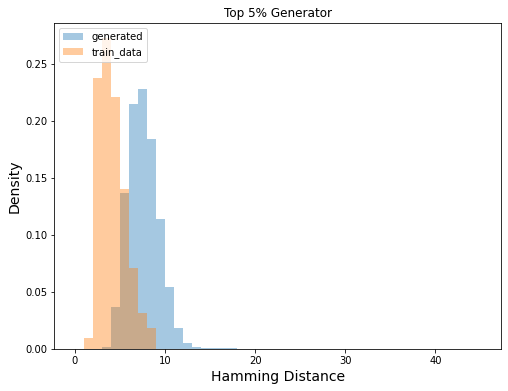

In [46]:
plt.figure(figsize=(8,6))
plt.hist(hamming_dist_list, density=True, label='generated', bins=[i for i in range(46)], alpha=0.4)
# plt.xlabel("Hamming Distance", size=14)
# plt.ylabel("Count", size=14)
# plt.title("Hamming Distance from WT seq")

plt.hist(gen_train_hamming_dist_list, density=True, label='train_data', bins=[i for i in range(46)], alpha=0.4)
plt.xlabel("Hamming Distance", size=14)
plt.ylabel("Density", size=14)
plt.title("Top 5% Generator")
plt.legend(loc='upper left')

# Sample for E[min] FoldX Computation

In [47]:
gen250k_df_filtered

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
81039,3.030911,-14.308747,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMEN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
61015,2.938221,-13.744923,SDIEEQAKSFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKSFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
73321,2.985047,-13.611472,SDIEEQAKTFLDKFNHEAEDLFYQSFLASMRYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSFLASWRYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
64398,2.949520,-13.560543,SNIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMEN...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
67559,2.961349,-13.530456,STIEEQAKTFLDKFNHEAESLFYQSSLASMNYNTNITEENVQNMNQ...,STIEEQAKTFLDKFNHEAESLFYQSSLASWNYNTNITEENVQNMQN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
250452,14.565163,5.093559,STIEEQARTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQARTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
251999,15.276659,5.147618,STIEEQAKTFLDKFNHEAEKLFYMSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEKLFYMSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
252453,15.423152,5.268487,STIEEQAKTFLDKFNHEAEILFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNHEAEILFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
251907,15.231038,5.524130,STIEEQAKTFLDKFNQEAESLFYQSKLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNQEAESLFYQSKLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


In [48]:
# Get topk seqs
num_rounds = 100 # N
round_pool_size = 10000
topk = 10 # K

round_topk = {}
cols_to_sort = ['latent_head_pred']
# cols_to_sort = ['disc_pred', 'latent_head_pred']

foldx_df = None
in_count = 0 
for col_to_sort in cols_to_sort:
    print("col_to_sort: ", col_to_sort)
    round_topk[col_to_sort] = {}
    for round_ind in range(num_rounds):
        sampled_rows = gen250k_df_filtered.sample(n=round_pool_size)
        sorted_sampled_rows = sampled_rows.sort_values(by=col_to_sort, ascending=True)[:topk]
        topk_rows = sorted_sampled_rows[:topk]
        round_topk[col_to_sort][round_ind] = topk_rows
    
    for round_ind in round_topk[col_to_sort]:
        round_topk_df = round_topk[col_to_sort][round_ind]
        if foldx_df is None:
            foldx_df = round_topk_df
        else:
            all_mt = foldx_df['MT_seq'].tolist()

            for row_ind, row in round_topk_df.iterrows():
                if row['MT_seq'] not in all_mt:
                    foldx_df = foldx_df.append(row)
                else:
                    in_count += 1
                    
    print("len(foldx_df)+in_count: ", len(foldx_df)+in_count)

col_to_sort:  latent_head_pred
len(foldx_df)+in_count:  1000


In [49]:
foldx_df

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen
53895,2.917477,-13.301193,SDIEEIAKTFLDKFNHEAMDLFYQSSLASMNYNTNITEENVQNMNN...,SDIEEIAKTFLDKFNHEAMDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
50668,2.909591,-13.037271,SDIEEQAKTFLDKFNHEAEDLFYQSSLKSMNYNTNITEENVRNMNN...,SDIEEQAKTFLDKFNHEAEDLFYQSSLKSWNYNTNITEENVRNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
62834,2.944002,-12.974091,SSIEEQAKTFLDSFNHEAEDLFYQSSLASMNYNTNITEENVQNMNN...,SSIEEQAKTFLDSFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
53470,2.916428,-12.920919,SDIEEQAKTFLDKFNHEANDLFFQSSLASMNYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAQDLFFQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
52462,2.913884,-12.706570,SDIEEQAKTFLDKFNREAEDLFYQSSLASMNYNTNITEENVQNMNE...,SDIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVQNMNE...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
...,...,...,...,...,...,...,...,...,...,...
51622,2.911746,-12.669415,STIEEQAKTFLDKFNREAEDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFNREAEDLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
69812,2.970117,-12.572781,STIEEQAKTFLDKFNHEAEDLFYQYSFASMNYNTNITEENVQNMFN...,STIEEQAKTFLDKFNHEAEDLFYQYSRASWNYNTNITEENVQNMFN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
51476,2.911426,-12.659915,SDIEEQAKTFLDIFNHEAEDLFYQFSLASMNYNTNITEENVQMMNN...,SDIEEQAKTFLDIFNHEAEDLFYQLSLASWNYNTNITEENVQMMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False
4791,2.822478,-12.515876,SDIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENMQNMNN...,SSIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENWQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False


In [50]:
in_count

676

# save E[min] seqs to do FoldX¶

In [51]:
seqsforEmin_dict_name = 'generated_seqs/congen/clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqsforEmin_df.pkl'
# seqsforEmin_dict_name = 'generated_seqs/congen/clspool_sephead512dim_lre-04_gen_perturb-1/unique250K_clspool_sephead512dim_lre-04_gen_perturb-1-congen_seqsforEmin_df.pkl'

if before_foldx:
    with open(seqsforEmin_dict_name, 'wb') as f:
        pickle.dump(round_topk, f)

# with open(seqsforEmin_dict_name, 'rb') as f:
#     b = pickle.load(f)

In [52]:
seqsforEmin_tsv_name = 'generated_seqs/congen/clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqsforEmin_foldx.tsv'
# seqsforEmin_tsv_name = 'generated_seqs/congen/clspool_sephead512dim_lre-04_gen_perturb-1/unique250K_clspool_sephead512dim_lre-04_gen_perturb-1-congen_seqsforEmin_foldx.tsv'

if before_foldx:
    foldx_df.to_csv(seqsforEmin_tsv_name, sep="\t", index=False)

# <<===== After Foldx Computation =====>>

In [53]:
# foldx_results_name = "path_to_foldx_results"
# # foldx_results_name = "foldx_sim_results/tophalf-basegen_top10K-Dscore_250Kgen/results_full.tsv"
# foldx_results_df = pd.read_table(foldx_results_name)



In [54]:
foldx_results_names = [
    "foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Klatentheadfiltered/results_full.tsv",   
#     "foldx_sim_results/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqs260000_top10Kdiscfiltered/results_full.tsv",
                      ]
# foldx_results_name = "foldx_sim_results/tophalf-basegen_top10K-Dscore_250Kgen/results_full.tsv"
foldx_results_df = None
for foldx_results_name in foldx_results_names:
    if foldx_results_df is None:
        foldx_results_df = pd.read_table(foldx_results_name)
    else:
        next_foldx_results_df = pd.read_table(foldx_results_name)
        foldx_results_df = foldx_results_df.append(next_foldx_results_df, ignore_index=True)



In [55]:
foldx_results_df

,disc_pred,latent_head_pred,MT_seq,gen_input_seq,PDB,Chain,Start_index,WT_seq,repeated_gen,in_train_data_gen,ddG
0,2.870699,-11.351077,STIEEQAKTFLDKFKHEAEDLFYQSTLASMNYNTNITEENVQNMNN...,STIEEQAKTFLDKFKHEAEDLFYQSTLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.37372
1,2.864015,-11.350984,STIEEQAKQFLDKFNHEALDLFYQSSLASMNYNTNITEENVQNMNN...,STIEEQAKQFLDKFNHEAEPLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-3.75880
2,2.866637,-11.350789,STIEEQAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENYQNMNN...,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENYQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.64235
3,2.830233,-11.350729,STIEEQAKTFLMKFNHEAEDLFYQSSLTQMNYNTNITEENVQNMNN...,STIEEQAKTMLDKFNHEAEDLFYQSSLTNWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-4.80446
4,2.920205,-11.350695,STIEELAKMFLMRFNHEAERLFYQSSLASMNYNTNITEENVQNMNN...,STIEELAKWFLWQFNHEAEFLFYQSSLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-5.05101
...,...,...,...,...,...,...,...,...,...,...,...
9995,2.844780,-12.188685,SDIEEQAKTFLDKFNHEAEDLFYQSSLAKMNYNTNITEENVQNMRN...,SDIEEQAKTFLDKFNHEAEDLFYQSSLAKWNYNTNITEENVQNMRN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-6.00398
9996,2.848111,-12.187910,SSIEELAKTFLDKFNHEAEDLFYQSSLASMNYNTNITEENVQFMNN...,SSIEELAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQFMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-5.47509
9997,2.858779,-12.187255,SDIEEQAKTFLDKFNHEAEDLFYISMLASMNYNTNITEENVQNMNN...,SDIEEQAKTFLDKFNHEAEDLFYISWLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-6.32746
9998,3.040434,-12.186877,SDIEEMAKTFLDKFNHMATDLFYQFMLASMNYNTNITEENVQNMNN...,SDIEEWAKTFLDKFNHMAVDLFYQRWLASWNYNTNITEENVQNMNN...,template2.pdb,A,19,STIEEQAKTFLDKFNHEAEDLFYQSSLASWNYNTNITEENVQNMNN...,False,False,-10.83210


In [56]:
# Compute Emin from foldx values
rows_to_patch = None
Emin_results_dict = {}
mean_disc_ddG_cor_results_dict = {}
mean_latent_ddG_cor_results_dict = {}

for col_to_sort in round_topk:
    print(col_to_sort)
    current_score_round_topk = round_topk[col_to_sort]
    
    round_min_list = []
    round_disc_ddG_cor_list = []
    round_latent_ddG_cor_list = []
    
    for round_ind in current_score_round_topk:
        round_topk_df = current_score_round_topk[round_ind]
        
        round_ddG = []
        round_disc_pred = []
        round_latent_head_pred = []
        for row_ind, row in round_topk_df.iterrows():
            row_seq = row['MT_seq']
            matched_row = foldx_results_df.loc[foldx_results_df['MT_seq'] == row_seq]
            if len(matched_row) != 1 :
#                 print("matched_row: ", matched_row)
                if len(matched_row) == 0 :
                    if rows_to_patch is None:
                        rows_to_patch = row
                    else:
                        rows_to_patch.append(row)
#                 raise
                else:
#                     round_ddG.append(matched_row.iloc[0]['ddG'].to_numpy()[0])
#                     round_disc_pred.append(matched_row.iloc[0]['disc_pred'].to_numpy()[0])
#                     round_latent_head_pred.append(matched_row.iloc[0]['latent_head_pred'].to_numpy()[0])
                    round_ddG.append(matched_row.iloc[0]['ddG'])
                    round_disc_pred.append(matched_row.iloc[0]['disc_pred'])
                    round_latent_head_pred.append(matched_row.iloc[0]['latent_head_pred'])
            else:        
#                 print("matched_row['ddG'] to_numpy: ", matched_row['ddG'].to_numpy())
#                 print("matched_row['ddG'] to_numpy 0: ", matched_row['ddG'].to_numpy()[0])
#                 print("matched_row['ddG']: ", matched_row['ddG'])
#                 print("matched_row['disc_pred']: ", matched_row['disc_pred'])
                round_ddG.append(matched_row['ddG'].to_numpy()[0]) # ! changed to ddG
                round_disc_pred.append(matched_row['disc_pred'].to_numpy()[0])
                round_latent_head_pred.append(matched_row['latent_head_pred'].to_numpy()[0])
#                 round_ddG.append(matched_row['ddG']) # ! changed to ddG
#                 round_disc_pred.append(matched_row['disc_pred'])
#                 round_latent_head_pred.append(matched_row['latent_head_pred'])
        
#         print("len(round_disc_pred): ", len(round_disc_pred))
#         print("len(round_ddG): ", len(round_ddG))
#         print("round_disc_pred: ", round_disc_pred)
#         print("round_ddG: ", round_ddG)
#         print("round_ddG.to_numpy(): ", round_ddG.to_numpy())
        round_disc_ddG_cor = spearmanr(round_disc_pred, round_ddG)
        round_disc_ddG_cor_list.append(round_disc_ddG_cor)
        round_latent_ddG_cor = spearmanr(round_latent_head_pred, round_ddG)
        round_latent_ddG_cor_list.append(round_latent_ddG_cor)
        
        round_min  = np.min(round_ddG)
#         print("round_ddG: ", round_ddG)
#         print("round_min: ", round_min)
        round_min_list.append(round_min)
        
    Emin = np.mean(round_min_list)
#     print("round_min_list: ", round_min_list)
#     print("Emin: ", Emin)
    mean_disc_ddG_cor = np.mean(round_disc_ddG_cor_list)
    mean_latent_ddG_cor = np.mean(round_latent_ddG_cor_list)
    
    Emin_results_dict[col_to_sort] = Emin
    mean_disc_ddG_cor_results_dict[col_to_sort] = mean_disc_ddG_cor
    mean_latent_ddG_cor_results_dict[col_to_sort] = mean_latent_ddG_cor

latent_head_pred


In [57]:
print(rows_to_patch)

None


# Save Emin Results

In [58]:
Emin_results_name = 'generated_seqs/congen/clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080/unique250K_clspool_waeDeterencStart84kstep1024dim_cyccon1Start84kstep_lre-04_24ep_gen_perturb-080-congen_seqsforEmin_results.txt'
# Emin_results_name = 'generated_seqs/baseline_gen/Emin_results/tophalf-basegen_seqsforEmin_results.txt'

In [59]:
with open(Emin_results_name, "w") as writer:
    writer.write("***** E[min] results *****\n")
    writer.write("seqsforEmin_dict_name: {}\n".format(seqsforEmin_dict_name))
    for key in sorted(Emin_results_dict.keys()):
        writer.write("sorted by %s = %s\n" % (key, str(Emin_results_dict[key])))
        
        
    writer.write("***** mean_disc_ddG_cor results *****\n")
    for key in sorted(mean_disc_ddG_cor_results_dict.keys()):
        writer.write("sorted by %s = %s\n" % (key, str(mean_disc_ddG_cor_results_dict[key])))
        
    writer.write("***** mean_latent_ddG_cor results *****\n")
    for key in sorted(mean_latent_ddG_cor_results_dict.keys()):
        writer.write("sorted by %s = %s\n" % (key, str(mean_latent_ddG_cor_results_dict[key])))